In [55]:
import random
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt

In [ ]:
class NeuralNetwork:
    LEARNING_RATE = 0.5

    def __init__(self, num_inputs, num_hidden_1, num_hidden_2, num_outputs, hidden_layer_1_weights=None, hidden_layer_1_activation="sigmoid", hidden_layer_1_bias=None, hidden_layer_2_weights=None, hidden_layer_2_activation="sigmoid", hidden_layer_2_bias=None, output_layer_weights=None, output_layer_activation="sigmoid", output_layer_bias=None):
        self.num_inputs = num_inputs
        self.hidden_layer_1 = NeuronLayer(
            num_hidden_1, hidden_layer_1_activation, hidden_layer_1_bias)
        self.hidden_layer_2 = NeuronLayer(
            num_hidden_2, hidden_layer_2_activation, hidden_layer_2_bias)
        self.output_layer = NeuronLayer(
            num_outputs, output_layer_activation, output_layer_bias)
        self.init_weights_from_inputs_to_hidden_layer_1_neurons(
            hidden_layer_1_weights)
        self.init_weights_from_hidden_layer_1_to_hidden_layer_2_neurons(
            hidden_layer_2_weights)
        self.init_weights_from_hidden_layer_2_neurons_to_output_layer_neurons(
            output_layer_weights)

    def init_weights_from_inputs_to_hidden_layer_1_neurons(self, hidden_layer_1_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer_1.neurons)):
            for i in range(self.num_inputs):
                if not hidden_layer_1_weights:
                    self.hidden_layer_1.neurons[h].weights.append(
                        random.random())
                else:
                    self.hidden_layer_1.neurons[h].weights.append(
                        hidden_layer_1_weights[weight_num])
                weight_num += 1
                self.hidden_layer_1.neurons[h].gradient.append(0)

    def init_weights_from_hidden_layer_1_to_hidden_layer_2_neurons(self, hidden_layer_2_weights):
        weight_num = 0
        for h in range(len(self.hidden_layer_2.neurons)):
            for i in range(len(self.hidden_layer_1.neurons)):
                if not hidden_layer_2_weights:
                    self.hidden_layer_2.neurons[h].weights.append(
                        random.random())
                else:
                    self.hidden_layer_2.neurons[h].weights.append(
                        hidden_layer_2_weights[weight_num])
                weight_num += 1
                self.hidden_layer_2.neurons[h].gradient.append(0)

    def init_weights_from_hidden_layer_2_neurons_to_output_layer_neurons(self, output_layer_weights):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer_2.neurons)):
                if not output_layer_weights:
                    self.output_layer.neurons[o].weights.append(
                        random.random())
                else:
                    self.output_layer.neurons[o].weights.append(
                        output_layer_weights[weight_num])
                weight_num += 1
                self.output_layer.neurons[o].gradient.append(0)

    def inspect(self):
        print('------')
        print('* Inputs: {}'.format(self.num_inputs))
        print('------')
        print('Hidden Layer 1')
        self.hidden_layer_1.inspect()
        print('------')
        print('Hidden Layer 2')
        self.hidden_layer_2.inspect()
        print('------')
        print('* Output Layer')
        self.output_layer.inspect()
        print('------')

    def feed_forward(self, inputs):
        hidden_layer_1_outputs = self.hidden_layer_1.feed_forward(inputs)
        hidden_layer_2_outputs = self.hidden_layer_2.feed_forward(
            hidden_layer_1_outputs)
        return self.output_layer.feed_forward(hidden_layer_2_outputs)

    def train(self, training_sets):
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            pd_errors_wrt_output_neuron_total_net_input = [
                0] * len(self.output_layer.neurons)
            for o in range(len(self.output_layer.neurons)):
                pd_errors_wrt_output_neuron_total_net_input[o] = self.output_layer.neurons[o].calculate_pd_error_wrt_total_net_input(
                    training_outputs[o])/len(training_sets)

            pd_errors_wrt_hidden_2_neuron_total_net_input = [
                0] * len(self.hidden_layer_2.neurons)
            for h in range(len(self.hidden_layer_2.neurons)):
                d_error_wrt_hidden_2_neuron_output = 0
                for o in range(len(self.output_layer.neurons)):
                    d_error_wrt_hidden_2_neuron_output += pd_errors_wrt_output_neuron_total_net_input[
                        o] * self.output_layer.neurons[o].weights[h]
                pd_errors_wrt_hidden_2_neuron_total_net_input[h] = d_error_wrt_hidden_2_neuron_output * \
                    self.hidden_layer_2.neurons[h].calculate_pd_total_net_input_wrt_input(
                )

            pd_errors_wrt_hidden_1_neuron_total_net_input = [
                0] * len(self.hidden_layer_1.neurons)
            for h in range(len(self.hidden_layer_1.neurons)):
                d_error_wrt_hidden_1_neuron_output = 0
                for o in range(len(self.hidden_layer_2.neurons)):
                    d_error_wrt_hidden_1_neuron_output += pd_errors_wrt_hidden_2_neuron_total_net_input[
                        o] * self.hidden_layer_2.neurons[o].weights[h]
                pd_errors_wrt_hidden_1_neuron_total_net_input[h] = d_error_wrt_hidden_1_neuron_output * \
                    self.hidden_layer_1.neurons[h].calculate_pd_total_net_input_wrt_input(
                )

            for o in range(len(self.output_layer.neurons)):
                for w_ho in range(len(self.output_layer.neurons[o].weights)):
                    if t == 0:
                        self.output_layer.neurons[o].gradient[w_ho] = 0
                    pd_error_wrt_weight = pd_errors_wrt_output_neuron_total_net_input[
                        o] * self.output_layer.neurons[o].calculate_pd_total_net_input_wrt_weight(w_ho)
                    self.output_layer.neurons[o].gradient[w_ho] += self.LEARNING_RATE * \
                        pd_error_wrt_weight

            for h in range(len(self.hidden_layer_2.neurons)):
                for w_hh in range(len(self.hidden_layer_2.neurons[h].weights)):
                    if t == 0:
                        self.hidden_layer_2.neurons[h].gradient[w_hh] = 0
                    pd_error_wrt_weight = pd_errors_wrt_hidden_2_neuron_total_net_input[
                        h] * self.hidden_layer_2.neurons[h].calculate_pd_total_net_input_wrt_weight(w_hh)
                    self.hidden_layer_2.neurons[h].gradient[w_hh] += self.LEARNING_RATE * \
                        pd_error_wrt_weight

            for h in range(len(self.hidden_layer_1.neurons)):
                for w_ih in range(len(self.hidden_layer_1.neurons[h].weights)):
                    if t == 0:
                        self.hidden_layer_1.neurons[h].gradient[w_ih] = 0
                    pd_error_wrt_weight = pd_errors_wrt_hidden_1_neuron_total_net_input[
                        h] * self.hidden_layer_1.neurons[h].calculate_pd_total_net_input_wrt_weight(w_ih)
                    self.hidden_layer_1.neurons[h].gradient[w_ih] += self.LEARNING_RATE * \
                        pd_error_wrt_weight

        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):
                self.output_layer.neurons[o].weights[w_ho] -= self.output_layer.neurons[o].gradient[w_ho]

        for h in range(len(self.hidden_layer_2.neurons)):
            for w_hh in range(len(self.hidden_layer_2.neurons[h].weights)):
                self.hidden_layer_2.neurons[h].weights[w_hh] -= self.hidden_layer_2.neurons[h].gradient[w_hh]

        for h in range(len(self.hidden_layer_1.neurons)):
            for w_ih in range(len(self.hidden_layer_1.neurons[h].weights)):
                self.hidden_layer_1.neurons[h].weights[w_ih] -= self.hidden_layer_1.neurons[h].gradient[w_ih]

    def undo(self):
        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):
                self.output_layer.neurons[o].weights[w_ho] += self.output_layer.neurons[o].gradient[w_ho]

        for h in range(len(self.hidden_layer_2.neurons)):
            for w_hh in range(len(self.hidden_layer_2.neurons[h].weights)):
                self.hidden_layer_2.neurons[h].weights[w_hh] += self.hidden_layer_2.neurons[h].gradient[w_hh]

        for h in range(len(self.hidden_layer_1.neurons)):
            for w_ih in range(len(self.hidden_layer_1.neurons[h].weights)):
                self.hidden_layer_1.neurons[h].weights[w_ih] += self.hidden_layer_1.neurons[h].gradient[w_ih]

    def calculate_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                total_error += self.output_layer.neurons[o].calculate_error(
                    training_outputs[o])/len(training_sets)
        return total_error


class NeuronLayer:
    def __init__(self, num_neurons, activation, bias):
        self.activation = activation
        self.bias = bias if bias else random.random()
        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.activation, self.bias))

    def inspect(self):
        print('Neurons:', len(self.neurons))
        for n in range(len(self.neurons)):
            print(' Neuron', n)
            for w in range(len(self.neurons[n].weights)):
                print('  Weight:', self.neurons[n].weights[w])
            print('  Bias:', self.bias)

    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs

    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs


class Neuron:
    def __init__(self, activation, bias):
        self.activation = activation
        self.bias = bias
        self.weights = []
        self.gradient = []

    def calculate_output(self, inputs):
        self.inputs = inputs
        self.output = self.squash(self.calculate_total_net_input())
        return self.output

    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias

    def squash(self, total_net_input):
        if self.activation == "relu":
            return max(0, total_net_input)
        else:
            return 1 / (1 + math.exp(-total_net_input))

    def calculate_pd_error_wrt_total_net_input(self, target_output):
        return self.calculate_pd_error_wrt_output(target_output) * self.calculate_pd_total_net_input_wrt_input()

    def calculate_error(self, target_output):
        return 0.5 * (target_output - self.output) ** 2

    def calculate_pd_error_wrt_output(self, target_output):
        return -(target_output - self.output)

    def calculate_pd_total_net_input_wrt_input(self):
        if self.activation == "relu":
            if self.output >= 0:
                return 1
            else:
                return 0
        else:
            return self.output * (1 - self.output)

    def calculate_pd_total_net_input_wrt_weight(self, index):
        return self.inputs[index]


df = pd.read_excel('HW3train.xlsx')
x0 = df['X_0']
x1 = df['X_1']
y = df['y'].tolist()
training_sets = []
for i in range(len(x0)):
    training_sets.append([[x0[i], x1[i]], [y[i]]])

df = pd.read_excel('HW3validate.xlsx')
x0 = df['X_0']
x1 = df['X_1']
y = df['y'].tolist()
validation_sets = []
for i in range(len(x0)):
    validation_sets.append([[x0[i], x1[i]], [y[i]]])



nn = NeuralNetwork(len(training_sets[0][0]), 10, 10, len(training_sets[0][1]))
x_epochs = [] # epochs on the x-axis
y_train = [] # mse train
y_val = [] # mse validation
epochs = 1
while epochs < 300:
    nn.train(training_sets)
    y_train.append(nn.calculate_total_error(training_sets))
    y_val.append(nn.calculate_total_error(validation_sets))
    x_epochs.append(epochs)
    epochs += 1

nn.undo()

In [87]:
y10 = [random.uniform(0,1) for i in range(len(x_epochs))]

ValueError: x and y must have same first dimension, but have shapes (299,) and (0,)

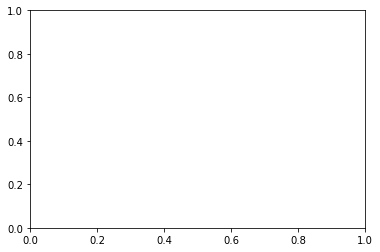

In [89]:
plt.plot(x_epochs, y_train, label='Training')
plt.plot(x_epochs, y_val, label='Validation')

plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.title("Plot of MSE over training and validation data")

plt.legend()

plt.show()
